# Simple Economic Dispatch
This notebook performs a simple economic dispatch on a 4-bus network with DC power flow. The simplifying assumptions used for DC pwoer flows are described <a href="https://www.engineering.iastate.edu/~jdm/ee553/DCPowerFlowEquations.pdf">here</a> and page 30 <a href="https://faculty.sites.iastate.edu/tesfatsi/archive/econ458/tesfatsion/lmp.AdvancedWPM.ELitvinovWEM301.pdf">here</a>.

In [5]:
# load packages
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.path import Path
import pandas as pd
import numpy as np
import math
import pulp as pulp
from itertools import chain
import functions_4bus # load function for displatch network

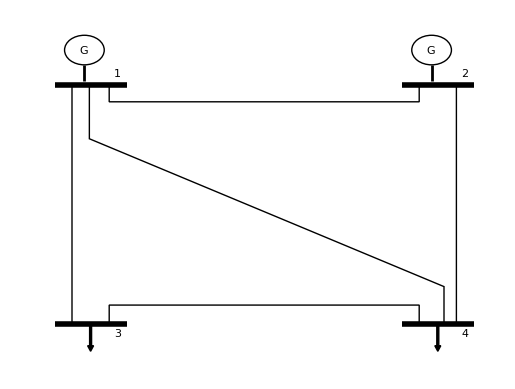

In [7]:
# show the network
functions_4bus.create_fig_4bus()

## Inputs
Inputs for the economic dispatch include the network model (buses, branches, susceptances, flow limits), generator attributes, and loads. Generators can offer up to three segements, each segment is (quantity, price) pair.


In [9]:
#### network inputs ####
# list bus ids
bus = [1,2,3,4]

# braches: (1,2) indicates a branch exist between buses 1 and 2
branches = [(1,2),(1,3),(1,4),(2,4),(3,4)]

# susceptances of branches
susceptances = {(1,2):10,(1,3):10,(1,4):10,(2,4):10,(3,4):10}

# branch flow limits
flow_limits = {(1,2):300,(1,3):300,(1,4):300,(2,4):300,(3,4):300}

# per-unit base is 100 MW
pu = 100

#### generator inputs ####
# generator output limits- (min, max)
gen_limits = {
    "A": (0,300),
    "B": (0,250)}

# generator segments- (quantity, price)
gen_segs = {
    'A': {
        1: (150,20), # seg 1- (incremental quantity, price)
        2: (100,25),
        3: (50,32)
        },
    'B': {
        1: (100,24),
        2: (100,29),
        3: (50,34)
        }
    }

# map generators to buses- no more than 1 gen per bus
bus_gen = {
    1: "A", # gen A is at bus 1
    2: "B"
    }

#### load inputs ####
# bus load- bus id and its 200MW load
bus_load = {1:0, 2:0, 3:200, 4:175}
tot_load = sum(bus_load.values()) # total system load


## Optimization Setup

### Decision Variables
The decision variables for the optimization problem are
- quantity (MW) each generator segment cleared
- quantity (MW) each generator is dispatched
- flow (MW) on each branch
- theta is the bus phase angle

In [11]:
# create pulp optimization problem
econ_dispatch = pulp.LpProblem("EconomicDispatch",pulp.LpMinimize)

#### decision variables ####

# seg_vars- quantity of each segment dispatched/cleared
# create a list of tuples, where each tuple is a (gen id, segment id)
gen_seg_index = []
# loop through gen_seg to find all the segs each gen has
for g in gen_segs:
    gen_seg_index.append([tuple((str(g),s)) for s in list(gen_segs[g].keys())])
# return one list/iterable of tuples
gen_seg_index = list(chain(*gen_seg_index))
# segment variables indicate how much of a segment is dispatched/cleared
seg_vars = pulp.LpVariable.dicts("gs",gen_seg_index,0)

# gen_vars- each generators output/dispatched quantity
gen_vars = pulp.LpVariable.dicts("g",gen_limits)

# flow_vars- power flowing on each branch
flow_vars = pulp.LpVariable.dicts('br',susceptances.keys())

# theta- phase angles for each bus
theta = pulp.LpVariable.dicts('theta',bus,-math.pi,math.pi)

### Objective Function and Constraints
The objective function is the sum of all generator segment costs. The goal of the economic dispatch problem is to minimize production costs subject to the constraints, including branch power flow limits, generator limits, and ensuring supply equals demand. 

In [13]:
#### objective function ####
econ_dispatch += pulp.lpSum(seg_vars[gs]*gen_segs[gs[0]][gs[1]][1] for gs in gen_seg_index)


#### constraints ####

# energy balance (gen = load)
econ_dispatch += (pulp.lpSum(gen_vars) == tot_load)

# power flow on each brach
for s in susceptances:
    econ_dispatch += (pu*susceptances[s]*(theta[s[0]]-theta[s[1]]) == flow_vars[s])

# power flow limits on each branch
for b in susceptances.keys():
    econ_dispatch += flow_vars[(b)] <= flow_limits[(b)] # limit flow from bus 1 -> 2
    econ_dispatch += flow_vars[(b)] >= -flow_limits[(b)] # limit flow from bus 2 -> 1

# bus power balance
# buses with gen
for b in bus_gen.keys():
    econ_dispatch += (-pulp.lpSum(flow_vars[s] for s in susceptances if s[0]==b) 
                      + pulp.lpSum(flow_vars[s] for s in susceptances if s[1]==b)
                      + gen_vars[bus_gen.get(b)]
                      - bus_load[b]
                      ==0
                      )
# buses without gen  
for b in (set(bus) - set(bus_gen.keys())):
    econ_dispatch += (- pulp.lpSum(flow_vars[s] for s in susceptances if s[0]==b) 
                      + pulp.lpSum(flow_vars[s] for s in susceptances if s[1]==b)
                      - bus_load[b]
                      ==0
                      )
    
# generator constraints
# gen variables- generator total output
# set gen limits
for g in gen_vars:
    econ_dispatch += (gen_vars[g] >= gen_limits[g][0]) # >= lower limit
    econ_dispatch += (gen_vars[g] <= gen_limits[g][1]) # <= upper limit

# constraint- sum of seg cleared must equal gen output
for g in gen_vars:
    econ_dispatch += (pulp.lpSum(seg_vars[(g,s)] for s in range(1,max(gen_segs[g].keys())+1)) == gen_vars.get(g))

# set upperbound for segment MW
for s in seg_vars:
    econ_dispatch += (seg_vars[s] <= gen_segs[s[0]][s[1]][0])

theta[1].setInitialValue(0)
theta[1].fixValue()

## Solution and Results
Solve the optimization problem and display the optimal values for the decision variables. The updated network figure at the bottom shwos the optimal power flows on each branch.

In [15]:
# solve check status
solver = pulp.PULP_CBC_CMD(msg=True,warmStart=True)
econ_dispatch.solve(solver)
print('Problem Status: ' + pulp.LpStatus[econ_dispatch.status])

Problem Status: Optimal


In [17]:
print(f'Objective Function Value: {pulp.value(econ_dispatch.objective)}')
optimal_x = {}
for v in econ_dispatch.variables():
    optimal_x[v.name] = v.varValue
pd.DataFrame.from_dict(optimal_x,orient="index", columns=['Optimal Value'])

Objective Function Value: 8625.0


,Optimal Value
"br_(1,_2)",-9.375000
"br_(1,_3)",153.125000
"br_(1,_4)",106.250000
"br_(2,_4)",115.625000
"br_(3,_4)",-46.875000
g_A,250.000000
g_B,125.000000
"gs_('A',_1)",150.000000
"gs_('A',_2)",100.000000
"gs_('A',_3)",0.000000


In [19]:
# get power flows on branches
pf_x = {br:val for br,val in optimal_x.items() if br in list(map(str,(list(flow_vars.values()))))} # power flow var values
flow_vars_str = {str(v):k for k,v in flow_vars.items()} # flow var dictionary with keys as strings (instead of pulp vars)
flow_mw = {flow_vars_str[g]:val for g,val in pf_x.items()}

In [21]:
# calculate bus net injections
gen_x = {g:val for g,val in optimal_x.items() if g in list(map(str,(list(gen_vars.values()))))} # gen var values
gen_vars_str = {str(v):k for k,v in gen_vars.items()} # gen var dict with keys as strings
gen_mw = {gen_vars_str[g]:val for g,val in gen_x.items()} # bus gen MW amounts
bus_gen_soln = {k:gen_mw[v] for k,v in bus_gen.items()} # bus gen amounts
# net inj  = gen - load
net_inj_mw = {k: bus_load[k]*-1 for k in bus_load}
for k in bus_load:
    if k in bus_gen_soln:
        net_inj_mw[k] = net_inj_mw[k] + bus_gen_soln[k]

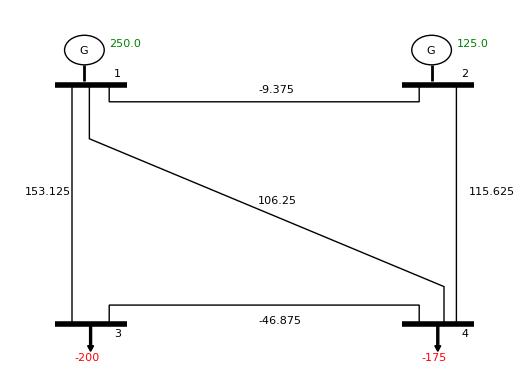

In [23]:
functions_4bus.create_fig_4bus(flow_mw,net_inj_mw)